# Comparison of model outputs

Aims: Compare probability predictions from logistic regression, random forests, and neural networks

## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [2]:
model_probs_test = pd.read_csv(
    './individual_model_output/probabilities_test.csv')

## Define the cutoff for classification

In [3]:
cut_off = 0.5

## Define function to set the colour for each point on the plot

In [4]:
def set_point_colour(s1, s2, cut_off):
    """
    s1 and s2 are series containing each model output for a number of instances
    cut_off is a float to classify each instance
    Returns series with a colour per instance to define whether there is a 
    match in the classification between the two models
    """
    # the classifications
    mask1 = s1 >= cut_off    
    mask2 = s2 >= cut_off
    mask3 = mask1 == mask2
    
    # initialise series with size the number of instances
    c = s1.copy(deep=True)
    # initialise with value 'r'
    c[:] = 'r'
    # value 'g' for those that match classification
    c[mask3] = 'g'
    
    return(c)

## Compare probababilties

Colour the points depending on whether the two models agree in their prediction.

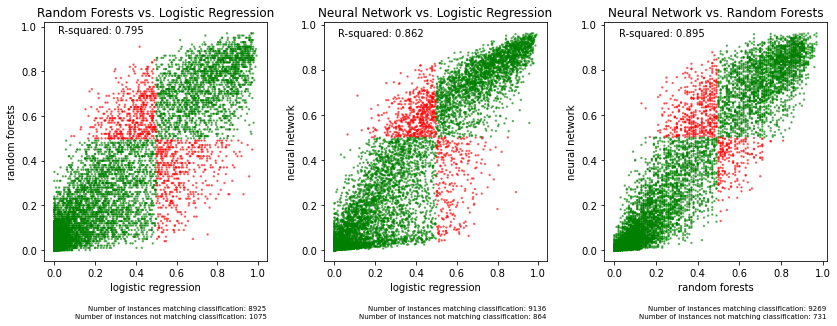

In [5]:
fig = plt.figure(figsize=(12,5))

# Random Forests vs. Logistic Regression
ax1 = fig.add_subplot(131)
r_square = np.corrcoef(model_probs_test['logistic_regression'],
           model_probs_test['random_forest'])[0][1] ** 2
c = set_point_colour(model_probs_test['logistic_regression'],
                     model_probs_test['random_forest'],
                     cut_off)
ax1.scatter(model_probs_test['logistic_regression'],
            model_probs_test['random_forest'],
            alpha=0.5, s=2, color = c)
ax1.set_xlabel('logistic regression')
ax1.set_ylabel('random forests')
ax1.set_title('Random Forests vs. Logistic Regression')
txt = f'R-squared: {r_square:0.3f}'
ax1.text(0.02, 0.97, txt)
# add a footnote below and to the right side of the chart about the count of 
# instance with matching classification
count_c = c.value_counts()
txt = f'Number of instances matching classification: {count_c.at["g"]}'
ax1.annotate(txt, xy = (1.0, -0.2), xycoords='axes fraction', ha='right', 
             va="center", fontsize=7)
txt = f'Number of instances not matching classification: {count_c.at["r"]}'
ax1.annotate(txt, xy = (1.0, -0.23), xycoords='axes fraction', ha='right', 
             va="center", fontsize=7)


# Neural network vs. Logistic Regression
ax2 = fig.add_subplot(132)
r_square = np.corrcoef(model_probs_test['logistic_regression'],
           model_probs_test['neural_net'])[0][1] ** 2
c = set_point_colour(model_probs_test['logistic_regression'],
                     model_probs_test['neural_net'],
                     cut_off)
ax2.scatter(model_probs_test['logistic_regression'],
            model_probs_test['neural_net'],
            alpha=0.5, s=2, color = c)
ax2.set_xlabel('logistic regression')
ax2.set_ylabel('neural network')
ax2.set_title('Neural Network vs. Logistic Regression')
txt = f'R-squared: {r_square:0.3f}'
ax2.text(0.02, 0.95, txt)
# add a footnote below and to the right side of the chart about the count of 
# instance with matching classification
count_c = c.value_counts()
txt = f'Number of instances matching classification: {count_c.at["g"]}'
ax2.annotate(txt, xy = (1.0, -0.2), xycoords='axes fraction', ha='right', 
             va="center", fontsize=7)
txt = f'Number of instances not matching classification: {count_c.at["r"]}'
ax2.annotate(txt, xy = (1.0, -0.23), xycoords='axes fraction', ha='right', 
             va="center", fontsize=7)


# Neural Network vs. Random Forests
ax3 = fig.add_subplot(133)
r_square = np.corrcoef(model_probs_test['random_forest'],
           model_probs_test['neural_net'])[0][1] ** 2
c = set_point_colour(model_probs_test['neural_net'],
                     model_probs_test['random_forest'],
                     cut_off)
ax3.scatter(model_probs_test['random_forest'],
           model_probs_test['neural_net'],
           alpha=0.5, s=2, color = c)
ax3.set_xlabel('random forests')
ax3.set_ylabel('neural network')
ax3.set_title('Neural Network vs. Random Forests')
txt = f'R-squared: {r_square:0.3f}'
ax3.text(0.02, 0.95, txt)
# add a footnote below and to the right side of the chart about the count of 
# instance with matching classification
count_c = c.value_counts()
txt = f'Number of instances matching classification: {count_c.at["g"]}'
ax3.annotate(txt, xy = (1.0, -0.2), xycoords='axes fraction', ha='right', 
             va="center", fontsize=7)
txt = f'Number of instances not matching classification: {count_c.at["r"]}'
ax3.annotate(txt, xy = (1.0, -0.23), xycoords='axes fraction', ha='right', 
             va="center", fontsize=7)

plt.tight_layout(pad=2)
plt.savefig('./ensemble_output/model_fits_scatter.png', dpi=300)
plt.show()

## Compare classification

In [6]:
classification = model_probs_test >= cut_off

Check agreement between logistic regression and random forests

In [7]:
agree = classification['logistic_regression'] == classification['random_forest']
np.mean(agree)

0.8925

Check agreement between logistic regression and neural network

In [8]:
agree = classification['logistic_regression'] == classification['neural_net']
np.mean(agree)

0.9136

Check agreement between random forests and neural network

In [9]:
agree = classification['random_forest'] == classification['neural_net']
np.mean(agree)

0.9269

Check agreement between all three model types

In [10]:
agree = (classification['logistic_regression'] == classification['random_forest']) & \
    (classification['logistic_regression'] == classification['neural_net'])
np.mean(agree)

0.8665